<a href="https://colab.research.google.com/github/yesong98/Exploration/blob/main/Exploration_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9.프로젝트: 인물 모드 문제점 찾기
<루브릭>
1. 인물모드 사진을 성공적으로 제작하였다.  
- 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.  
- 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.  
- 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 인물, 동물 사진 아웃포커싱


## 1) 사람

(2160, 2160, 3)


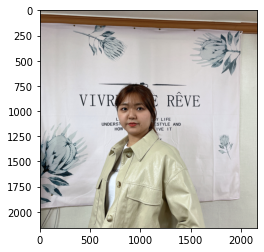

In [3]:
img_path = '/content/drive/MyDrive/aiffel/human_segmentation/images/IMG_9121.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = '/content/drive/MyDrive/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/content/drive/MyDrive/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa8bf6f1590>)

In [5]:
# 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

#PASCAL VOC데이터의 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 출력값 살펴보기

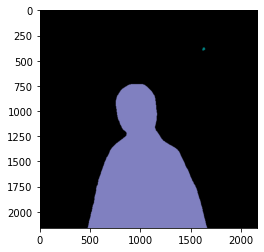

In [6]:
plt.imshow(output)
plt.show()

In [7]:
segvalues

{'class_ids': array([ 0,  3, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [8]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bird
person


In [9]:
# PixelLib 코드
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [10]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

(2160, 2160)


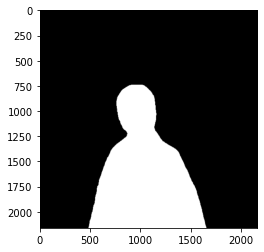

In [11]:
seg_color = (128,128,192)

#이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

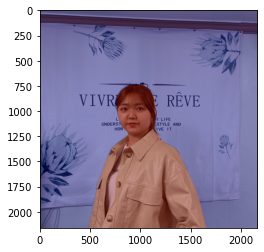

In [12]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경흐리게 하기

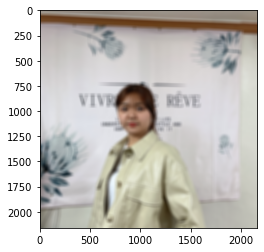

In [13]:
#blur함수 사용
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (40,40))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

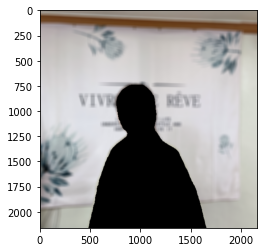

In [14]:
#세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

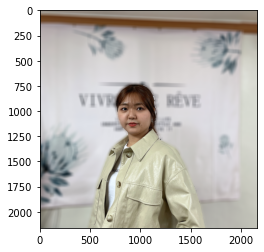

In [15]:
#흐린배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2) 동물

(620, 620, 3)


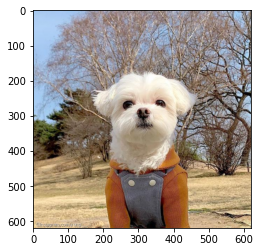

In [16]:
img_path = '/content/drive/MyDrive/aiffel/human_segmentation/images/dog.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# 저장할 파일 이름을 결정합니다
model_dir = '/content/drive/MyDrive/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

# 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

#PASCAL VOC데이터의 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

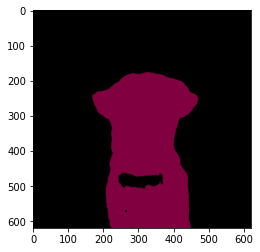

In [18]:
# 출력값 살펴보기
plt.imshow(output)
plt.show()

In [19]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [20]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [21]:
# PixelLib 코드
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [22]:
# dog을 나타내는 12번째 색상
colormap[12]

array([ 64,   0, 128])

(620, 620)


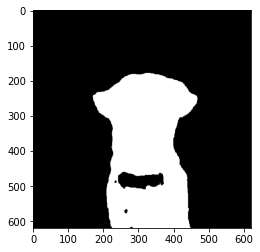

In [24]:
seg_color = (128,0,64)

#이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

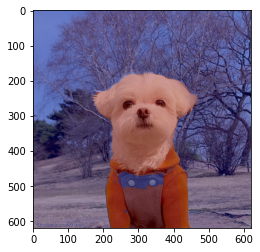

In [25]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경흐리게

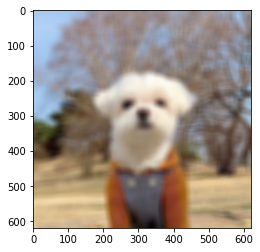

In [26]:
#blur함수 사용
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (20,20))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

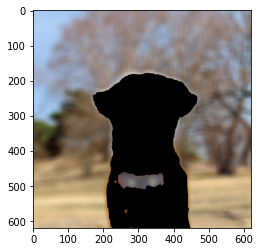

In [27]:
#세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

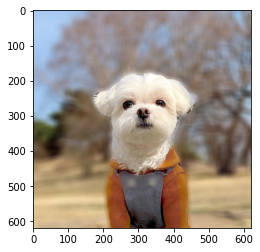

In [28]:
#흐린배경과 원본 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경합성하기

(2160, 2160, 3)


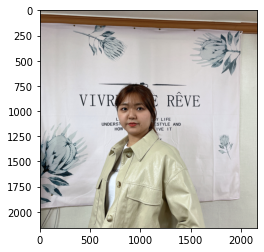

In [29]:
img_path = '/content/drive/MyDrive/aiffel/human_segmentation/images/IMG_9121.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(2160, 2160)


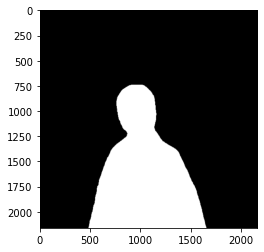

In [31]:
# 사람 저장할 파일 이름
model_dir = '/content/drive/MyDrive/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

# 세그멘테이션 모델을 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

# PixelLib 코드
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[15]
seg_color = (128,128,192)
#이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

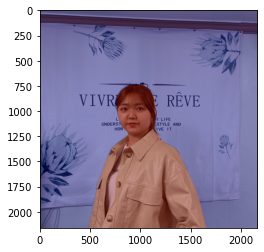

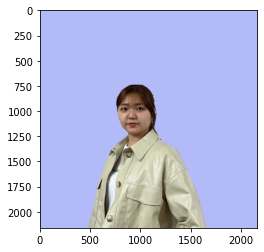

In [33]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 세그멘테이션 결과를 원래 크기로 복원하기
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

# 배경 이미지 불러오기
bg_path = '/content/drive/MyDrive/aiffel/human_segmentation/images/puple.png'
bg_orig = cv2.imread(bg_path)
target_size = (img_orig.shape[1], img_orig.shape[0])
bg_resized = cv2.resize(bg_orig, target_size)
    
# 배경과 원본 이미지 합성 후 저장
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, img_orig, bg_resized)
save_path = '/content/drive/MyDrive/aiffel/human_segmentation/models'


plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 회고
### 1. 과정
이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리 가능하다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있다. 우리는 다음과 같은 과정을 거쳐 후가공으로 '인물사진 모드'인 사진을 만들 수 있다.  

1. 배경이 있는 셀카를 촬영 (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리
3. 블러링(blurring) 기술로 배경을 흐리게 한 후 피사체를 배경의 원래 위치에 합성(배경 합성에서는 합성할 배경을 불러온 후 피사체를 배경의 원래 위치에 합성한다)

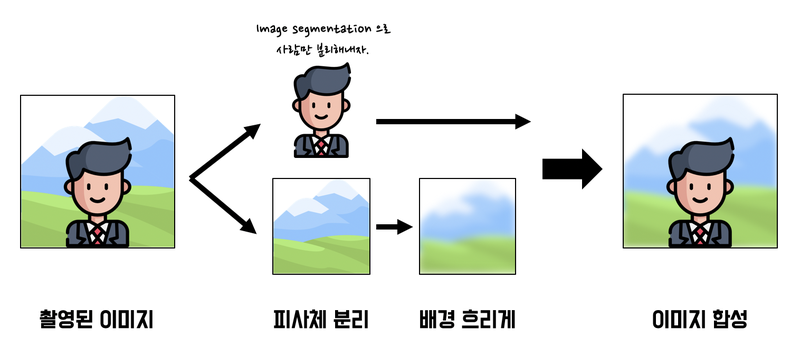

### 2. 문제점

1) 인물 사진에서는 아래 사진과 같이 배경이 인물에 포함되어 배경을 확실히 블러처리 하지 못한 문제가 발생했다.


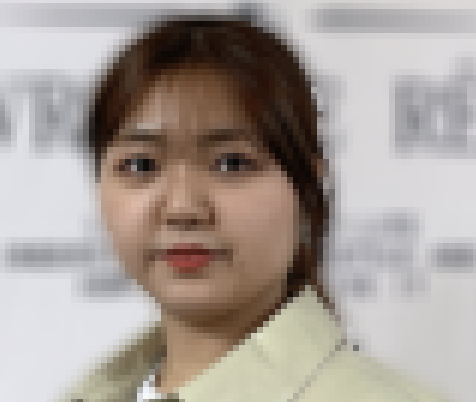

2) 강아지 사진에서는 귀의 털이 배경으로 같이 블러처리가되고 강아지 옷의 단추부분도 함께 배경에 포함되어 블러처리되는 현상을 보였다


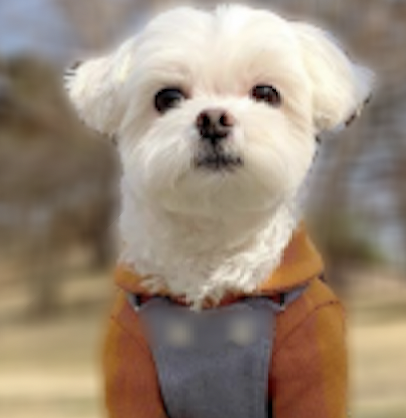

3) 배경합성의 문제점
- 대체적으로 합성이 잘 되었다고 볼 수 있지만 머리카락과 배경의 글자부분에서 약간의 혼동으로 경계의 모호함이 보인다.

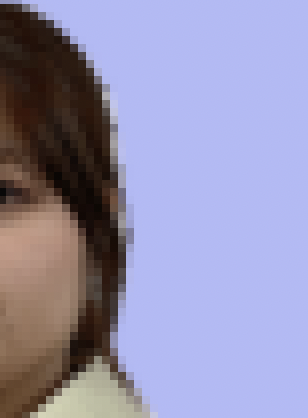

### 3. 문제점 해결

mage segmentation 접근 방법에 따라서 전통적인 방법으로는 3가지 방식으로 분류가 가능하다.

1. Pixel 기반 방법 : threshold에 기반한 방식으로 histogram을 이용해 픽셀들의 분포를 확인한 후 적절한 threshold를 설정하고, pixel 별로 나눈다.
2. Edge 기반 방법 : Edge를 추출하는 필터를 이용해서 edge를 추출해서 의미 있는 edge와 의미 없는 edge를 서로 구별하는 방식을 사용한다.
3. Region 기반 방법 : pixel이나 Edge에 기반한 방식으로는 의미 있는 영역으로 구별하는 것이 쉽지 않고, 특히 noise가 많으면 오차가 심하다. 영역으로 분할하는 방법은 영역의 동질성(homogeneity)를 기반으로 하여 의미 있는 영역끼리 나누는데 적합하지만 동질성을 나타내는 rule을 어떻게 정하는지가 중요하다.

지금 사용한 방법은 Pixel 기반 방법이기 때문에 가장 오차가 적을 것으로 예상되는 Region 기반 방법을 이용한다면 위와 같은 문제점들이 해결될 것이라 생각된다.